<a href="https://colab.research.google.com/github/harshitdxt3004/deep-learning/blob/main/anime_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

In [3]:
!cat kaggle.json > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d splcher/animefacedataset

 99% 389M/395M [00:14<00:00, 19.8MB/s]
100% 395M/395M [00:14<00:00, 27.8MB/s]


In [4]:
!unzip animefacedataset.zip -d animefacedataset > /dev/null

In [5]:
import os

DATA_DIR='./animefacedataset'
print(os.listdir(DATA_DIR+'/images')[:10])

['33442_2011.jpg', '18991_2007.jpg', '35351_2011.jpg', '41461_2013.jpg', '23866_2008.jpg', '31871_2010.jpg', '51918_2015.jpg', '25195_2009.jpg', '50085_2015.jpg', '23324_2008.jpg']


In [6]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [7]:
image_size = 64
batch_size = 128
stats = (0.5,0.5,0.5),(0.5,0.5,0.5)

In [9]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
]))

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=3, 
                      pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Helper functions

In [10]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
def denorm(img_tensors):
  return img_tensors * stats[1][0] + stats[0][0]

In [12]:
def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1,2,0))

def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


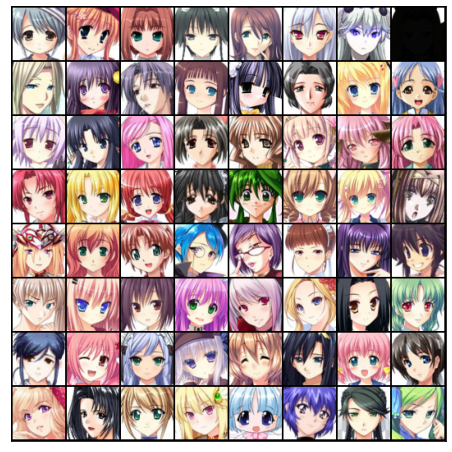

In [13]:
show_batch(train_dl)

In [14]:
def get_default_device():
  """Pick GPU if available, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  """Move tensors to chosen device"""
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
  
  def __iter__(self):
    """Yield a batch of data after moving it to a device"""
    for b in self.dl:
      yield to_device(b, self.device)
    
  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
train_dl = DeviceDataLoader(train_dl, device)

Discriminator network

In [17]:
import torch.nn as nn

In [18]:
discriminator = nn.Sequential(
    
    # in : 3 x 64 x 64
    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out : 64 x 32 x 32
    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out : 128 x 16 x 16
    nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out : 256 x 8 x 8
    nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out : 512 x 4 x 4
    nn.Conv2d(512, 1, kernel_size=4,stride=1,padding=0, bias=False),
    # out : 1 x 1 x 1
    nn.Flatten(),
    nn.Sigmoid())

In [19]:
discriminator = to_device(discriminator, device)

In [20]:
latent_size =  128

In [21]:
generator = nn.Sequential(
    # in : latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0,bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    # out : 512 x 4 x 4
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    # out : 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out : 64 x 32 x 32
    
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out : 3 x 64 x 64
    )

Test Generator

torch.Size([128, 3, 64, 64])


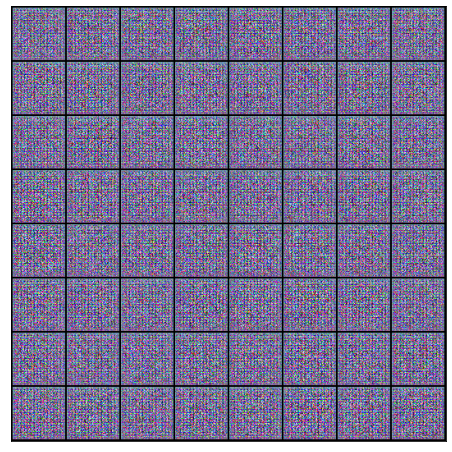

In [22]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [23]:
generator = to_device(generator, device)

In [24]:
def train_discriminator(real_images, opt_d):
  # Clear discriminator gradients
  opt_d.zero_grad()

  # Pass real images through discriminator
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  # Generate fake images
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  # Generate fake images through discriminator
  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  # Update discriminator weights
  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score

In [25]:
def train_generator(opt_g):
  # Clear generator gradients
  opt_g.zero_grad()

  # Generate fake images
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  # Try to fool the discriminator
  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)

  # Update generator weights
  loss.backward()
  opt_g.step()
  
  return loss.item()

Test directory

In [26]:
from torchvision.utils import save_image

In [27]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [28]:
def save_samples(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir,fake_fname), nrow=8)
  print('Saving', fake_fname)
  if show:
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [29]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


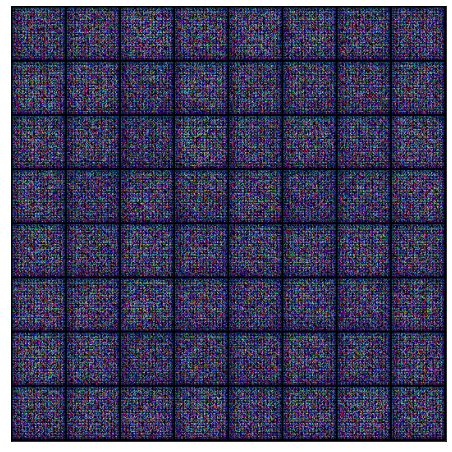

In [30]:
save_samples(0,fixed_latent)

Training

In [31]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [32]:
def fit(epochs, lr, start_idx=1):
  torch.cuda.empty_cache()

  # Losses and scores
  losses_g = [ ]
  losses_d = [ ]
  real_scores = [ ]
  fake_scores = [ ]

  # Optimizers
  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(),lr=lr, betas=(0.5, 0.999))
  for epoch in range(epochs):
    for real_images, _ in tqdm(train_dl):
      #Train discriminator
      loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
      #Train generator
      loss_g = train_generator(opt_g)

    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    #Logger
    print("Epoch {}/{}, loss_g:{:.4f}, loss_d:{:.4f}, real_score:{:.4f}, fake_score:{:.4f}".format(
    epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

    save_samples(epoch+start_idx, fixed_latent, show=False)
    
  return losses_g, losses_d, real_scores, fake_scores

In [33]:
lr = 0.0002
epochs=100

In [34]:
history = fit(epochs, lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch 1/100, loss_g:3.0855, loss_d:0.5873, real_score:0.7136, fake_score:0.1508
Saving generated-images-0001.png



Epoch 2/100, loss_g:7.6434, loss_d:0.9209, real_score:0.9674, fake_score:0.5308
Saving generated-images-0002.png



Epoch 3/100, loss_g:4.6910, loss_d:0.5385, real_score:0.6741, fake_score:0.0157
Saving generated-images-0003.png



Epoch 4/100, loss_g:7.2164, loss_d:0.8495, real_score:0.5345, fake_score:0.0006
Saving generated-images-0004.png



Epoch 5/100, loss_g:7.2872, loss_d:0.1797, real_score:0.8640, fake_score:0.0061
Saving generated-images-0005.png



Epoch 6/100, loss_g:4.9842, loss_d:0.2351, real_score:0.8877, fake_score:0.0936
Saving generated-images-0006.png



Epoch 7/100, loss_g:9.4657, loss_d:0.3639, real_score:0.9632, fake_score:0.2447
Saving generated-images-0007.png



Epoch 8/100, loss_g:4.8946, loss_d:0.1552, real_score:0.9352, fake_score:0.0720
Saving generated-images-0008.png



Epoch 9/100, loss_g:6.1621, loss_d:0.0398, real_score:0.9649, fake_score:0.0019
Saving generated-images-0009.png



Epoch 10/100, loss_g:7.5661, loss_d:0.1046, real_score:0.9936, fake_score:0.0826
Saving generated-images-0010.png



Epoch 11/100, loss_g:4.2488, loss_d:0.0645, real_score:0.9664, fake_score:0.0259
Saving generated-images-0011.png



Epoch 12/100, loss_g:5.5040, loss_d:0.1839, real_score:0.9471, fake_score:0.1086
Saving generated-images-0012.png



Epoch 13/100, loss_g:2.9013, loss_d:0.2387, real_score:0.8285, fake_score:0.0231
Saving generated-images-0013.png



Epoch 14/100, loss_g:4.9990, loss_d:0.0684, real_score:0.9617, fake_score:0.0225
Saving generated-images-0014.png



Epoch 15/100, loss_g:5.5737, loss_d:0.0620, real_score:0.9596, fake_score:0.0173
Saving generated-images-0015.png



Epoch 16/100, loss_g:5.6369, loss_d:0.1811, real_score:0.9632, fake_score:0.1193
Saving generated-images-0016.png



Epoch 17/100, loss_g:8.8647, loss_d:0.5180, real_score:0.9996, fake_score:0.3177
Saving generated-images-0017.png



Epoch 18/100, loss_g:5.4592, loss_d:0.1284, real_score:0.9686, fake_score:0.0790
Saving generated-images-0018.png



Epoch 19/100, loss_g:10.8321, loss_d:0.3598, real_score:0.7640, fake_score:0.0001
Saving generated-images-0019.png



Epoch 20/100, loss_g:7.8030, loss_d:0.1271, real_score:0.8984, fake_score:0.0050
Saving generated-images-0020.png



Epoch 21/100, loss_g:2.7908, loss_d:0.1227, real_score:0.9334, fake_score:0.0366
Saving generated-images-0021.png



Epoch 22/100, loss_g:5.4258, loss_d:0.1264, real_score:0.9901, fake_score:0.0988
Saving generated-images-0022.png



Epoch 23/100, loss_g:4.9198, loss_d:0.0964, real_score:0.9756, fake_score:0.0634
Saving generated-images-0023.png



Epoch 24/100, loss_g:4.5637, loss_d:0.2191, real_score:0.9405, fake_score:0.1313
Saving generated-images-0024.png



Epoch 25/100, loss_g:4.3543, loss_d:0.0774, real_score:0.9491, fake_score:0.0162
Saving generated-images-0025.png



Epoch 26/100, loss_g:4.2441, loss_d:0.0859, real_score:0.9701, fake_score:0.0473
Saving generated-images-0026.png



Epoch 27/100, loss_g:4.2696, loss_d:0.1169, real_score:0.9217, fake_score:0.0205
Saving generated-images-0027.png



Epoch 28/100, loss_g:6.0632, loss_d:0.2436, real_score:0.9562, fake_score:0.1433
Saving generated-images-0028.png



Epoch 29/100, loss_g:4.3098, loss_d:0.1173, real_score:0.9640, fake_score:0.0662
Saving generated-images-0029.png



Epoch 30/100, loss_g:9.1250, loss_d:0.0633, real_score:0.9458, fake_score:0.0017
Saving generated-images-0030.png



Epoch 31/100, loss_g:4.6589, loss_d:0.1317, real_score:0.8994, fake_score:0.0111
Saving generated-images-0031.png



Epoch 32/100, loss_g:5.2289, loss_d:0.0699, real_score:0.9902, fake_score:0.0536
Saving generated-images-0032.png



Epoch 33/100, loss_g:4.5493, loss_d:0.1298, real_score:0.9434, fake_score:0.0593
Saving generated-images-0033.png



Epoch 34/100, loss_g:0.6540, loss_d:0.2300, real_score:0.8284, fake_score:0.0139
Saving generated-images-0034.png



Epoch 35/100, loss_g:3.5417, loss_d:0.7530, real_score:0.5813, fake_score:0.0090
Saving generated-images-0035.png



Epoch 36/100, loss_g:4.6651, loss_d:0.0800, real_score:0.9428, fake_score:0.0069
Saving generated-images-0036.png



Epoch 37/100, loss_g:5.1265, loss_d:0.1302, real_score:0.9278, fake_score:0.0263
Saving generated-images-0037.png


KeyboardInterrupt: ignored